In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.dropout(self.pool1(x))
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [5]:
batch_size = 128
# Load CIFAR10 train dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
print(len(train_set))

# Load test dataset
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
test_loader = DataLoader(test_set, batch_size, shuffle=False, num_workers=2)
print(len(test_set))

# Calculate mean and standard deviation of the dataset
mean = train_set.data.mean(axis=(0,1,2)) / 255  # Calculate mean
std = train_set.data.std(axis=(0,1,2)) / 255    # Calculate standard deviation

# Define transforms including whitening
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Calculate mean and standard deviation of the dataset
mean = test_set.data.mean(axis=(0,1,2)) / 255  # Calculate mean
std = test_set.data.std(axis=(0,1,2)) / 255    # Calculate standard deviation

# Define transforms including whitening
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# regenerate datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform1)
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform2)
test_loader = DataLoader(test_set, batch_size, shuffle=False, num_workers=2)


0.6%

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
50000
Files already downloaded and verified
10000


In [6]:
# Create an instance of the CNN model
model = CNN()
model.to('cuda')
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epoch = 50

# logs
loss_hists = {'train':[],'test': []}
acc_hists = {'train':[],'test': []}

# Train the model
for epoch in range(num_epoch):  # loop over the dataset multiple times
    train_loss = 0
    correct_num = 0
    for data in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epoch}"):
        model.train()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        pred = outputs.argmax(dim=1)
        correct_num += (pred == labels).sum().item()
        
    average_loss = train_loss/len(train_loader)
    acc = correct_num/(len(train_loader)*batch_size)
    loss_hists['train'].append(average_loss)
    acc_hists['train'].append(acc)
    print(f"Epoch {epoch + 1}/{num_epoch}, Training Loss: {average_loss:.4f}, Training accuracy: {acc:.4f}")
    
    model.eval()
    with torch.no_grad():
        correct_num = 0
        val_loss = 0
        for test_data in test_loader:
            
            test_inputs, test_labels = test_data
            test_inputs, test_labels = test_inputs.to('cuda'), test_labels.to('cuda')
            test_output = model(test_inputs)
            loss = criterion(test_output,test_labels)
            val_loss+=loss
            
            test_pred = test_output.argmax(dim=1)
            correct_num += (test_pred == test_labels).sum().item()
            
        acc = correct_num/ (len(test_loader)*batch_size)
        average_val_loss = val_loss/len(test_loader)
        
        loss_hists['test'].append(average_val_loss)
        acc_hists['test'].append(acc)
        print(f'Epoch {epoch + 1}/{num_epoch}, Validation loss: {average_val_loss:.4f}, Validation accuracy: {acc:.4f}')


Epoch 1/50: 100%|██████████| 391/391 [00:02<00:00, 188.50it/s]

Epoch 1/50, Training Loss: 1.5015, Training accuracy: 0.4480


Epoch 1/50, Validation loss: 1.2753, Validation accuracy: 0.5405


Epoch 2/50: 100%|██████████| 391/391 [00:01<00:00, 218.75it/s]

Epoch 2/50, Training Loss: 1.0865, Training accuracy: 0.6142


Epoch 2/50, Validation loss: 0.9554, Validation accuracy: 0.6601


Epoch 3/50: 100%|██████████| 391/391 [00:01<00:00, 217.05it/s]

Epoch 3/50, Training Loss: 0.9085, Training accuracy: 0.6822


Epoch 3/50, Validation loss: 0.8479, Validation accuracy: 0.6961


Epoch 4/50: 100%|██████████| 391/391 [00:01<00:00, 216.04it/s]

Epoch 4/50, Training Loss: 0.7996, Training accuracy: 0.7217


Epoch 4/50, Validation loss: 0.8214, Validation accuracy: 0.7056


Epoch 5/50: 100%|██████████| 391/391 [00:01<00:00, 214.29it/s]

Epoch 5/50, Training Loss: 0.7320, Training accuracy: 0.7451


Epoch 5/50, Validation loss: 0.7720, Validation accuracy: 0.7286


Epoch 6/50: 100%|██████████| 391/391 [00:01<00:00, 215.75it/s]

Epoch 6/50, Training Loss: 0.6756, Training accuracy: 0.7643


Epoch 6/50, Validation loss: 0.7432, Validation accuracy: 0.7408


Epoch 7/50: 100%|██████████| 391/391 [00:01<00:00, 216.87it/s]

Epoch 7/50, Training Loss: 0.6307, Training accuracy: 0.7795


Epoch 7/50, Validation loss: 0.7378, Validation accuracy: 0.7441


Epoch 8/50: 100%|██████████| 391/391 [00:01<00:00, 217.55it/s]

Epoch 8/50, Training Loss: 0.5895, Training accuracy: 0.7903


Epoch 8/50, Validation loss: 0.7595, Validation accuracy: 0.7360


Epoch 9/50: 100%|██████████| 391/391 [00:01<00:00, 215.27it/s]

Epoch 9/50, Training Loss: 0.5533, Training accuracy: 0.8046


Epoch 9/50, Validation loss: 0.7206, Validation accuracy: 0.7485


Epoch 10/50: 100%|██████████| 391/391 [00:01<00:00, 217.54it/s]

Epoch 10/50, Training Loss: 0.5229, Training accuracy: 0.8128


Epoch 10/50, Validation loss: 0.7683, Validation accuracy: 0.7451


Epoch 11/50: 100%|██████████| 391/391 [00:01<00:00, 216.77it/s]

Epoch 11/50, Training Loss: 0.4931, Training accuracy: 0.8256


Epoch 11/50, Validation loss: 0.7233, Validation accuracy: 0.7566


Epoch 12/50: 100%|██████████| 391/391 [00:01<00:00, 213.39it/s]

Epoch 12/50, Training Loss: 0.4687, Training accuracy: 0.8319


Epoch 12/50, Validation loss: 0.7222, Validation accuracy: 0.7608


Epoch 13/50: 100%|██████████| 391/391 [00:01<00:00, 215.73it/s]

Epoch 13/50, Training Loss: 0.4459, Training accuracy: 0.8410


Epoch 13/50, Validation loss: 0.7450, Validation accuracy: 0.7507


Epoch 14/50: 100%|██████████| 391/391 [00:01<00:00, 217.09it/s]

Epoch 14/50, Training Loss: 0.4253, Training accuracy: 0.8479


Epoch 14/50, Validation loss: 0.7560, Validation accuracy: 0.7600


Epoch 15/50: 100%|██████████| 391/391 [00:01<00:00, 216.66it/s]

Epoch 15/50, Training Loss: 0.3978, Training accuracy: 0.8579


Epoch 15/50, Validation loss: 0.7520, Validation accuracy: 0.7670


Epoch 16/50: 100%|██████████| 391/391 [00:01<00:00, 222.63it/s]

Epoch 16/50, Training Loss: 0.3846, Training accuracy: 0.8624


Epoch 16/50, Validation loss: 0.7874, Validation accuracy: 0.7661


Epoch 17/50: 100%|██████████| 391/391 [00:01<00:00, 218.09it/s]

Epoch 17/50, Training Loss: 0.3741, Training accuracy: 0.8655


Epoch 17/50, Validation loss: 0.8238, Validation accuracy: 0.7560


Epoch 18/50: 100%|██████████| 391/391 [00:01<00:00, 217.89it/s]

Epoch 18/50, Training Loss: 0.3627, Training accuracy: 0.8683


Epoch 18/50, Validation loss: 0.7891, Validation accuracy: 0.7611


Epoch 19/50: 100%|██████████| 391/391 [00:01<00:00, 229.21it/s]

Epoch 19/50, Training Loss: 0.3491, Training accuracy: 0.8755


Epoch 19/50, Validation loss: 0.8231, Validation accuracy: 0.7588


Epoch 20/50: 100%|██████████| 391/391 [00:01<00:00, 224.13it/s]

Epoch 20/50, Training Loss: 0.3369, Training accuracy: 0.8799


Epoch 20/50, Validation loss: 0.8191, Validation accuracy: 0.7570


Epoch 21/50: 100%|██████████| 391/391 [00:01<00:00, 229.95it/s]

Epoch 21/50, Training Loss: 0.3229, Training accuracy: 0.8844


Epoch 21/50, Validation loss: 0.8062, Validation accuracy: 0.7559


Epoch 22/50: 100%|██████████| 391/391 [00:01<00:00, 229.60it/s]

Epoch 22/50, Training Loss: 0.3096, Training accuracy: 0.8906


Epoch 22/50, Validation loss: 0.8745, Validation accuracy: 0.7586


Epoch 23/50: 100%|██████████| 391/391 [00:01<00:00, 225.40it/s]

Epoch 23/50, Training Loss: 0.3102, Training accuracy: 0.8898


Epoch 23/50, Validation loss: 0.9120, Validation accuracy: 0.7625


Epoch 24/50: 100%|██████████| 391/391 [00:01<00:00, 229.52it/s]

Epoch 24/50, Training Loss: 0.2908, Training accuracy: 0.8971


Epoch 24/50, Validation loss: 0.8676, Validation accuracy: 0.7562


Epoch 25/50: 100%|██████████| 391/391 [00:01<00:00, 227.89it/s]

Epoch 25/50, Training Loss: 0.2880, Training accuracy: 0.8984


Epoch 25/50, Validation loss: 0.9003, Validation accuracy: 0.7541


Epoch 26/50: 100%|██████████| 391/391 [00:01<00:00, 226.73it/s]

Epoch 26/50, Training Loss: 0.2790, Training accuracy: 0.9025


Epoch 26/50, Validation loss: 0.9319, Validation accuracy: 0.7587


Epoch 27/50: 100%|██████████| 391/391 [00:01<00:00, 220.89it/s]

Epoch 27/50, Training Loss: 0.2856, Training accuracy: 0.9012


Epoch 27/50, Validation loss: 0.9129, Validation accuracy: 0.7585


Epoch 28/50: 100%|██████████| 391/391 [00:01<00:00, 225.45it/s]

Epoch 28/50, Training Loss: 0.2705, Training accuracy: 0.9053


Epoch 28/50, Validation loss: 0.9057, Validation accuracy: 0.7591


Epoch 29/50: 100%|██████████| 391/391 [00:01<00:00, 216.92it/s]

Epoch 29/50, Training Loss: 0.2696, Training accuracy: 0.9057


Epoch 29/50, Validation loss: 0.9756, Validation accuracy: 0.7536


Epoch 30/50: 100%|██████████| 391/391 [00:01<00:00, 222.10it/s]

Epoch 30/50, Training Loss: 0.2591, Training accuracy: 0.9117


Epoch 30/50, Validation loss: 1.0046, Validation accuracy: 0.7586


Epoch 31/50: 100%|██████████| 391/391 [00:01<00:00, 215.46it/s]

Epoch 31/50, Training Loss: 0.2691, Training accuracy: 0.9070


Epoch 31/50, Validation loss: 0.9764, Validation accuracy: 0.7547


Epoch 32/50: 100%|██████████| 391/391 [00:01<00:00, 214.38it/s]

Epoch 32/50, Training Loss: 0.2521, Training accuracy: 0.9117


Epoch 32/50, Validation loss: 0.9982, Validation accuracy: 0.7570


Epoch 33/50: 100%|██████████| 391/391 [00:01<00:00, 209.04it/s]

Epoch 33/50, Training Loss: 0.2426, Training accuracy: 0.9147


Epoch 33/50, Validation loss: 1.0208, Validation accuracy: 0.7565


Epoch 34/50: 100%|██████████| 391/391 [00:01<00:00, 219.26it/s]

Epoch 34/50, Training Loss: 0.2483, Training accuracy: 0.9147


Epoch 34/50, Validation loss: 1.0205, Validation accuracy: 0.7588


Epoch 35/50: 100%|██████████| 391/391 [00:01<00:00, 220.95it/s]

Epoch 35/50, Training Loss: 0.2444, Training accuracy: 0.9161


Epoch 35/50, Validation loss: 1.0372, Validation accuracy: 0.7577


Epoch 36/50: 100%|██████████| 391/391 [00:01<00:00, 223.63it/s]

Epoch 36/50, Training Loss: 0.2473, Training accuracy: 0.9144


Epoch 36/50, Validation loss: 1.0898, Validation accuracy: 0.7543


Epoch 37/50: 100%|██████████| 391/391 [00:01<00:00, 216.02it/s]

Epoch 37/50, Training Loss: 0.2467, Training accuracy: 0.9165


Epoch 37/50, Validation loss: 1.0574, Validation accuracy: 0.7601


Epoch 38/50: 100%|██████████| 391/391 [00:01<00:00, 221.74it/s]

Epoch 38/50, Training Loss: 0.2303, Training accuracy: 0.9224


Epoch 38/50, Validation loss: 1.0824, Validation accuracy: 0.7507


Epoch 39/50: 100%|██████████| 391/391 [00:01<00:00, 214.75it/s]

Epoch 39/50, Training Loss: 0.2277, Training accuracy: 0.9223


Epoch 39/50, Validation loss: 1.1175, Validation accuracy: 0.7589


Epoch 40/50: 100%|██████████| 391/391 [00:01<00:00, 219.53it/s]

Epoch 40/50, Training Loss: 0.2325, Training accuracy: 0.9219


Epoch 40/50, Validation loss: 1.0809, Validation accuracy: 0.7555


Epoch 41/50: 100%|██████████| 391/391 [00:01<00:00, 221.49it/s]

Epoch 41/50, Training Loss: 0.2248, Training accuracy: 0.9239


Epoch 41/50, Validation loss: 1.1207, Validation accuracy: 0.7563


Epoch 42/50: 100%|██████████| 391/391 [00:01<00:00, 222.74it/s]

Epoch 42/50, Training Loss: 0.2199, Training accuracy: 0.9243


Epoch 42/50, Validation loss: 1.1717, Validation accuracy: 0.7544


Epoch 43/50: 100%|██████████| 391/391 [00:01<00:00, 228.23it/s]

Epoch 43/50, Training Loss: 0.2185, Training accuracy: 0.9272


Epoch 43/50, Validation loss: 1.1736, Validation accuracy: 0.7531


Epoch 44/50: 100%|██████████| 391/391 [00:01<00:00, 221.64it/s]

Epoch 44/50, Training Loss: 0.2253, Training accuracy: 0.9241


Epoch 44/50, Validation loss: 1.1686, Validation accuracy: 0.7627


Epoch 45/50: 100%|██████████| 391/391 [00:01<00:00, 222.83it/s]

Epoch 45/50, Training Loss: 0.2276, Training accuracy: 0.9231


Epoch 45/50, Validation loss: 1.1909, Validation accuracy: 0.7566


Epoch 46/50: 100%|██████████| 391/391 [00:01<00:00, 218.15it/s]

Epoch 46/50, Training Loss: 0.2275, Training accuracy: 0.9244


Epoch 46/50, Validation loss: 1.1269, Validation accuracy: 0.7550


Epoch 47/50: 100%|██████████| 391/391 [00:01<00:00, 221.33it/s]

Epoch 47/50, Training Loss: 0.2183, Training accuracy: 0.9269


Epoch 47/50, Validation loss: 1.1911, Validation accuracy: 0.7539


Epoch 48/50: 100%|██████████| 391/391 [00:01<00:00, 222.84it/s]

Epoch 48/50, Training Loss: 0.2129, Training accuracy: 0.9282


Epoch 48/50, Validation loss: 1.1796, Validation accuracy: 0.7602


Epoch 49/50: 100%|██████████| 391/391 [00:01<00:00, 216.42it/s]

Epoch 49/50, Training Loss: 0.2119, Training accuracy: 0.9301


Epoch 49/50, Validation loss: 1.2022, Validation accuracy: 0.7478


Epoch 50/50: 100%|██████████| 391/391 [00:01<00:00, 225.46it/s]

Epoch 50/50, Training Loss: 0.2121, Training accuracy: 0.9306


Epoch 50/50, Validation loss: 1.2127, Validation accuracy: 0.7575


In [7]:
# Save dictionary as Pickle
with open("./result/adagrad-dropout-loss-50.pkl", "wb") as loss_file:
    pickle.dump(loss_hists, loss_file)
with open("./result/adagrad-dropout-acc-50.pkl", "wb") as acc_file:
    pickle.dump(acc_hists, acc_file)

# draw the loss figures
fig, ax = plt.subplots(1,2)
ax[0].plot(torch.tensor(loss_hists['train']).cpu().detach().numpy()) # can only matplotlib to plot numpy on CPU
ax[0].plot(torch.tensor(loss_hists['test']).cpu().detach().numpy())
ax[0].set_title('Loss-Epoch')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Loss')
ax[0].legend(['Training loss', 'Validation loss'])

ax[1].plot(torch.tensor(acc_hists['train']).cpu().detach().numpy())
ax[1].plot(torch.tensor(acc_hists['test']).cpu().detach().numpy())
ax[1].set_title('Acc-Epoch')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Training acc', 'Validation acc'])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './result/adagrad-dropout-loss-50.pkl'

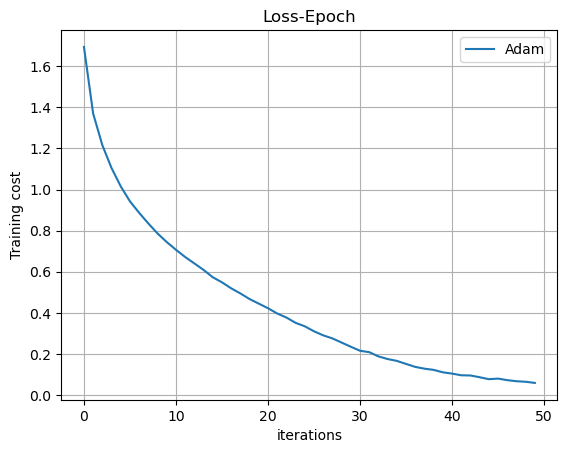

In [ ]:
# draw the loss figures
with open('./result/adam-loss-50.pkl','rb') as f:
    loss_hists = pickle.load(f)
 

plt.plot(torch.tensor(loss_hists['train']).cpu().detach().numpy())
# Customize the plot
plt.xlabel('iterations')  # X-axis label
plt.ylabel('Training cost')  # Y-axis label
plt.title('Loss-Epoch')  # Title
plt.grid(True)  # Add grid lines
plt.legend(['Adam'])  # Add legend

# Show the plot
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=50):
        super(VAE, self).__init__()
        # Define the encoder layers
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.Softplus(),
            nn.Linear(500, latent_dim * 2)  # Two sets of outputs: mean and log(variance)
        )
        
        # Define the decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 500),
            nn.Softplus(),
            nn.Linear(500, input_dim),
            nn.Sigmoid()  # Output values in the range [0, 1]
        )

    def encode(self, x):
        # Encode the input to get the mean and log(variance) of the latent space
        h = self.encoder(x)
        mean, log_var = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mean, log_var

    def reparameterize(self, mean, log_var):
        # Reparameterization trick: sample from the Gaussian with mean and variance
        epsilon = torch.randn_like(log_var)
        z = mean + torch.exp(0.5 * log_var) * epsilon
        return z

    def decode(self, z):
        # Decode the latent space representation
        return self.decoder(z)

    def forward(self, x):
        # Forward pass through the VAE
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        x_recon = self.decode(z)
        return x_recon, mean, log_var

# Define the loss function
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

class AdamOptimizer:
    def __init__(self, params, bias_cor, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = list(params)
        self.lr = torch.tensor(lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = torch.tensor(0)
        self.m = [torch.zeros_like(p) for p in self.params]  # 初始化self.m列表
        self.v = [torch.zeros_like(p) for p in self.params]  # 初始化self.v列表
        self.bias_cor = bias_cor

    def step(self):
        if self.bias_cor == True:
            self.t += 1
        lr_t = self.lr * (torch.sqrt(1 - self.beta2 ** self.t) / (1 - self.beta1 ** self.t))
        for i, p in enumerate(self.params):
            if p.grad is not None:
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * p.grad ** 2
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                p.data -= lr_t * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.data.zero_()

            

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define hyperparameters
input_size = 784
hidden_size = 500
latent_size = 50
batch_size = 128
lr = 1e-3
beta1 = 0.9
beta2 = 0.999
num_epochs = 10
bias_correction = True

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# Initialize VAE model and optimizer
model = VAE(input_size, latent_size)
# Create an instance of the Adam optimizer
adam_optimizer = AdamOptimizer(model.parameters(), bias_correction, lr, beta1, beta2)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0
    for (data, _) in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        data = data.view(batch_size, -1)
        adam_optimizer.zero_grad()
        data_hat, mu, log_var = model(data)
        loss = loss_function(data, data_hat, mu, log_var)
        loss.backward()
        # Get gradients
        train_loss+=loss
        # Perform optimization step
        adam_optimizer.step()
        
    average_loss = train_loss/(len(train_loader)*batch_size)
        
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_loss:.4f}")

Epoch 1/10: 100%|██████████| 468/468 [00:14<00:00, 32.48it/s]


Epoch 1/10, Training Loss: 193.9590


Epoch 2/10: 100%|██████████| 468/468 [00:14<00:00, 32.98it/s]


Epoch 2/10, Training Loss: 138.8825


Epoch 3/10: 100%|██████████| 468/468 [00:14<00:00, 32.11it/s]


Epoch 3/10, Training Loss: 124.6981


Epoch 4/10: 100%|██████████| 468/468 [00:14<00:00, 32.31it/s]


Epoch 4/10, Training Loss: 117.6992


Epoch 5/10: 100%|██████████| 468/468 [00:15<00:00, 29.32it/s]


Epoch 5/10, Training Loss: 114.0754


Epoch 6/10: 100%|██████████| 468/468 [00:16<00:00, 27.72it/s]


Epoch 6/10, Training Loss: 111.8835


Epoch 7/10: 100%|██████████| 468/468 [00:14<00:00, 33.03it/s]


Epoch 7/10, Training Loss: 110.2804


Epoch 8/10: 100%|██████████| 468/468 [00:17<00:00, 27.30it/s]


Epoch 8/10, Training Loss: 109.0882


Epoch 9/10: 100%|██████████| 468/468 [00:18<00:00, 24.79it/s]


Epoch 9/10, Training Loss: 108.1784


Epoch 10/10: 100%|██████████| 468/468 [00:14<00:00, 33.04it/s]

Epoch 10/10, Training Loss: 107.5031
